# Projeto de IA

In [1]:
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random as rd

filepath_trettel = '/home/trettel/Documents/projects/DATALAB/datasets/Iris_Data.csv'
filepath_eric = '/home/grayjack/MySources/WorkshopML/data/Iris_Data.csv'

In [2]:
data = pd.read_csv(filepath_eric)
print(data.describe())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [3]:
data.groupby('species').agg(['mean', 'median'])
data.groupby('species').agg([np.mean, np.median])

sepal_length        sepal_width        petal_length         \
                        mean median        mean median         mean median   
species                                                                      
Iris-setosa            5.006    5.0       3.418    3.4        1.464   1.50   
Iris-versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
Iris-virginica         6.588    6.5       2.974    3.0        5.552   5.55   

                petal_width         
                       mean median  
species                             
Iris-setosa           0.244    0.2  
Iris-versicolor       1.326    1.3  
Iris-virginica        2.026    2.0

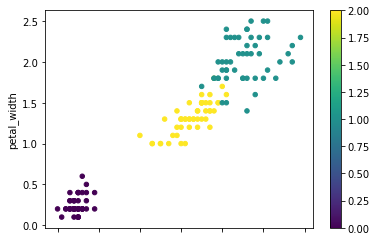

In [4]:
num = {val:i for i,val in enumerate(set(data.species))}
y_true = [num[item] for item in data.species]

data.plot.scatter(x="petal_length", y="petal_width", c=y_true, colormap='viridis')

In [5]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)

In [6]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [7]:
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True

In [8]:
def calculateAllDistances(positions, centroids, distFunction=euclidianDistance):
    distances = list()
    for pos in positions:
        list_per_cent = list()
        for index, cent in enumerate(centroids):
            list_per_cent.append(distFunction(cent, pos))

        distances.append(list_per_cent)

    return distances

In [9]:
def giveOwnership(distances):
    label = list()
    for dist in distances:
        min_dist = min(dist)
        label.append(dist.index(min_dist))

    return label

In [10]:
def generateCentroids(list_x, list_y, k):
    (min_x, min_y) = (min(list_x)-(min(list_x)*0.2),\
                      min(list_y)-(min(list_y)*0.2))
    (max_x, max_y) = (max(list_x)+(max(list_x)*0.2),\
                      max(list_y)+(max(list_y)*0.2))

    return [(rd.uniform(min_x, max_x), rd.uniform(min_y, max_y)) for i in range(k)]

In [11]:
def updateCentroids(positions, labels, k):
    new_centroids = list()
    for i in range(k):
        qtd = len([x for x in labels if x == i])
        point = [0, 0]
        for j, pos in enumerate(positions):
            if labels[j] == i:
                point[0] += pos[0]
                point[1] += pos[1]

        point[0] /= qtd + 0.000000000001
        point[1] /= qtd + 0.000000000001
        new_centroids.append((point[0], point[1]))

    return new_centroids

In [12]:
def kmeans(list_x, list_y, k=1, iter_times=100000, distFunction=euclidianDistance):
    positions = list(zip(list_x, list_y))
    centroids = generateCentroids(list_x, list_y, k)
    distances = calculateAllDistances(positions, centroids, distFunction)
    labels = giveOwnership(distances)

    iter = 0
    has_changed = True

    while has_changed and iter <= iter_times:
        centroids = updateCentroids(positions, labels, k)
        distances = calculateAllDistances(positions, centroids, distFunction)
        labels = giveOwnership(distances)

        iter += 1

    return labels, centroids

Melhor valor para o K:   5
Obtendo uma acurácia de: 0.8365829144738788 (v_measure_score) 



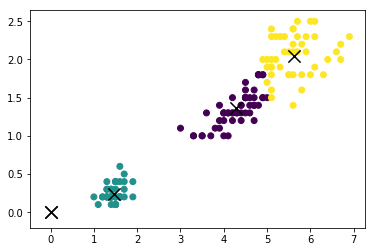

In [13]:
MAX_ITER = 15
document = zip(data.petal_length, data.petal_width)

best_accuracy = -1
best_centr = None
y_pred = []
best_label = []
best_k = 0

for K in range(1, 50):
    y_pred, centroids = kmeans(data.petal_length, data.petal_width, k=K, iter_times=MAX_ITER, distFunction=euclidianDistance)
    
#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    accuracy = metrics.v_measure_score(y_true, y_pred)

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} (v_measure_score) \n")
plotter(document, best_centr, best_label)